In [69]:
import keras
import pandas as pd
from keras import layers, Sequential
import argparse
from tensorflow.keras.layers import BatchNormalization, Conv1D, MaxPooling1D, Activation, Dropout, Dense, Flatten
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
import numpy as np
from keras.models import load_model
from keras.optimizers import Adam

In [70]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--dataset", type=str, required=True,
                help="data.csv")

ap.add_argument("-o", "--save", type=str, required=True,
                help="model.h5")

args = {
    "dataset": "data.csv",
    "save": "model.h5"
}

In [71]:
path_csv = args["dataset"]
path_to_save = args["save"]

In [ ]:

df = pd.read_csv(path_csv)
class_list = df['Pose_Class'].unique()
class_list = sorted(class_list)
class_number = len(class_list)

x = df.copy()
y = x.pop('Pose_Class')
y, _ = y.factorize()
x = x.astype('float64')
y = keras.utils.to_categorical(y)

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1,
                                                    random_state=42)
print(x_train.shape)
input_dim = 132

(865, 132)


In [ ]:
from keras import layers
from keras import regularizers
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(512, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(class_number, activation='softmax'),
])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 130, 64)           256       
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 65, 64)            0         
 ng1D)                                                           
                                                                 
 batch_normalization_35 (Ba  (None, 65, 64)            256       
 tchNormalization)                                               
                                                                 
 conv1d_21 (Conv1D)          (None, 63, 128)           24704     
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 31, 128)           0         
 ng1D)                                                           
                                                      

In [75]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.5
    return lr

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

print(lr_scheduler)

In [ ]:

checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)


In [ ]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, earlystopping, lr_scheduler])

Epoch 1/100
27/28 [===========================>..] - ETA: 0s - loss: 8.7990 - accuracy: 0.3519
Epoch 1: val_accuracy improved from -inf to 0.19588, saving model to model.h5
28/28 [==============================] - 5s 59ms/step - loss: 8.7986 - accuracy: 0.3514 - val_loss: 8.3870 - val_accuracy: 0.1959 - lr: 0.0010
Epoch 2/100
 1/28 [>.............................] - ETA: 1s - loss: 8.3742 - accuracy: 0.4688

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - ETA: 0s - loss: 7.7963 - accuracy: 0.4902
Epoch 2: val_accuracy did not improve from 0.19588
28/28 [==============================] - 1s 46ms/step - loss: 7.7963 - accuracy: 0.4902 - val_loss: 7.8101 - val_accuracy: 0.1959 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 6.7851 - accuracy: 0.5572
Epoch 3: val_accuracy did not improve from 0.19588
28/28 [==============================] - 2s 62ms/step - loss: 6.7851 - accuracy: 0.5572 - val_loss: 7.4533 - val_accuracy: 0.1959 - lr: 0.0010
Epoch 4/100
27/28 [===========================>..] - ETA: 0s - loss: 5.8752 - accuracy: 0.6238
Epoch 4: val_accuracy did not improve from 0.19588
28/28 [==============================] - 2s 64ms/step - loss: 5.8753 - accuracy: 0.6243 - val_loss: 7.0679 - val_accuracy: 0.1959 - lr: 0.0010
Epoch 5/100
27/28 [===========================>..] - ETA: 0s - loss: 5.0499 - accuracy: 0.6644
Epoch 5: val_accuracy did not improve from 0.19588

In [ ]:
np.save("labels.npy", class_list)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print("Precision:", precision)

recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print("F1-score:", f1)
loaded_model = load_model('model.h5')
overall_accuracy = loaded_model.evaluate(x_test, y_test)[1]
print('Overall Accuracy:', overall_accuracy)

4/4 [==============================] - 0s 7ms/step
Precision: 0.9010493372606774
Recall: 0.8865979381443299
F1-score: 0.8860490041098869
4/4 [==============================] - 0s 8ms/step - loss: 0.6854 - accuracy: 0.9588
Overall Accuracy: 0.9587628841400146


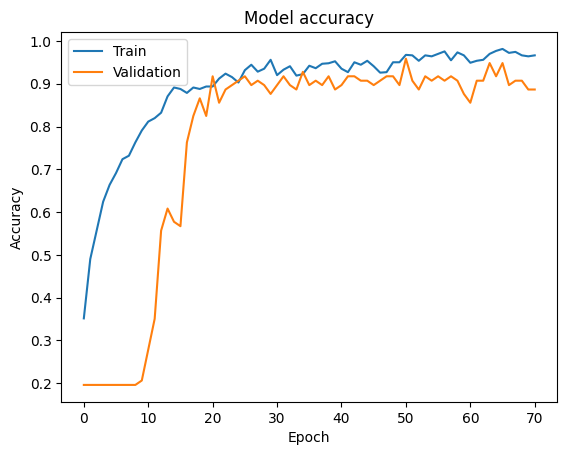

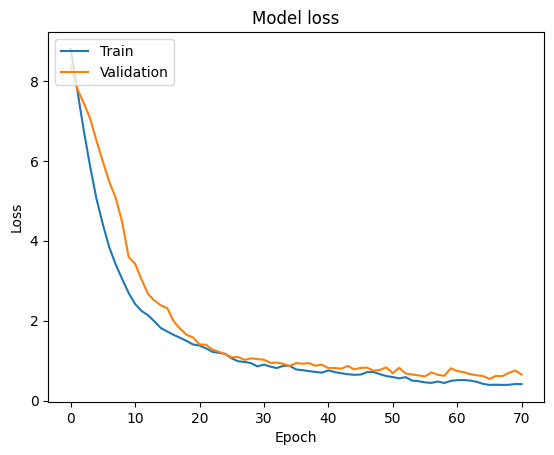

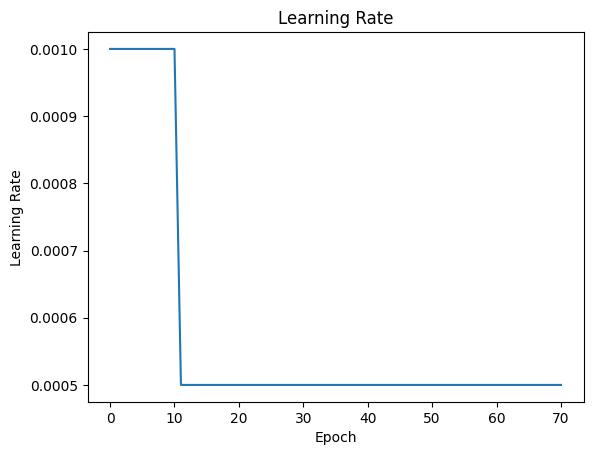

In [ ]:
def plot_training_history(history):
    # Plot Training & Validation Accuracy Values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('accuracy.png')
    plt.show()

    # Plot Training & Validation Loss Values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('loss.png')
    plt.show()

    # Plot Learning Rate Values
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.savefig('lr.png')
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
classification_report_result = classification_report(y_true_classes, y_pred_classes, target_names=class_list)
print("Classification Report:")
print(classification_report_result)

confusion_matrix_result = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(confusion_matrix_result)
np.save("labels.npy",class_list)

Classification Report:
              precision    recall  f1-score   support

     downdog       1.00      1.00      1.00        19
     goddess       0.71      0.88      0.79        17
       plank       0.86      1.00      0.92        24
        tree       1.00      0.81      0.90        16
    warrior2       0.94      0.71      0.81        21

    accuracy                           0.89        97
   macro avg       0.90      0.88      0.88        97
weighted avg       0.90      0.89      0.89        97

Confusion Matrix:
[[19  0  0  0  0]
 [ 0 15  1  0  1]
 [ 0  0 24  0  0]
 [ 0  2  1 13  0]
 [ 0  4  2  0 15]]
